# 112_model_zoo_pca_as_factor.ipynb
Running the hyperparameter tuning, using PCA output as factors and not just the entirety of the imaging data.

See `111_model_zoo.ipynb` to run the simulation using all of the 531 radiomics features as imputs.

In [ ]:
import pandas as pd
from pathlib import Path

# Read in data from CSV files
path = Path.cwd().parent.parent

# Here, we are using the coordinate for each patient based on the first principal component for each subgroup
trainPatientID = (pd.read_csv(path / "data" / "processed" / "trainDataPatientID.csv")
                  .drop(['Unnamed: 0'], axis=1))

pc = pd.read_csv(path / "data" / "interim" / "pc_by_feature_group_for_patients.csv")
pc.rename(columns={'Patient.ID': 'Patient ID'}, inplace=True)
pc = pc[pc['Patient ID'].isin(trainPatientID['Patient.ID'])]

clin = pd.read_csv(path / "data" / "raw" / "clinicalData_clean.csv")
clin = clin[clin['Patient ID'].isin(trainPatientID['Patient.ID'])]

# Clean the data- drop rows with NaN values
TARGET = 'Mol Subtype'
data = pc.merge(clin[['Patient ID', TARGET]], on='Patient ID', how='inner')
# NA has already been dropped
data = data.drop('Unnamed: 0', axis=1, errors='ignore')


from sklearn.preprocessing import LabelEncoder
# Select the target variable and merge with imaging data
y = data[TARGET]

# Encode target if needed - some models require numerical targets
if y.dtype == 'object' or y.dtype.name == 'category':
    le = LabelEncoder()
    y = le.fit_transform(y)

# Drop the target and patient ID columns to get the feature set
X = data.drop([TARGET, 'Patient ID'], axis=1, errors='ignore')

## Define search grids for RF, XGB, MLP
A *search grid* is a set of hyperparameter values that are tested in order to find the optimal configuration.

In [26]:
from skopt.space import Categorical, Real, Integer # Required for MLPClassifier grid search

# RandomForestClassifier search grid
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
rf_grid = {
    'n_estimators': [100, 200, 500], # number of trees in the forest
    'max_depth': [None, 5, 10, 20], # maximum depth of tree (how many splits allowed)
    'min_samples_split': [2, 5, 10], # minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4], # minimum number of samples required to be at a leaf node
    
    'bootstrap': [True, False] # whether bootstrap samples are used when building trees
    # if bootstrap is False, the whole dataset is used to build each tree
    # if bootstrap is True, each tree is built on a random sample of the data with
}

# XGBoost Classifier search grid
xgb_grid = {
    'n_estimators': [100, 200, 500], # number of trees in the ensemble
    'max_depth': [3, 5, 10], # maximum depth of a tree
    'learning_rate': [0.01, 0.1, 0.2], # step size shrinkage used in update to prevent overfitting
    'subsample': [0.7, 0.8, 1.0], # fraction of samples to be used for each tree
    'colsample_bytree': [0.7, 0.8, 1.0] # fraction of features to be used for each tree

}

# MLPClassifier search grid
mlp_grid = {
    'hidden_layer_sizes': Integer(50, 100),  # Only single-layer, sizes 50 to 100
    'activation': Categorical(['relu', 'tanh']),
    'solver': Categorical(['adam', 'sgd']),
    'alpha': Real(0.0001, 0.01, prior='log-uniform'),
    'learning_rate_init': Real(0.001, 0.01, prior='log-uniform')
}

## Bayesian search for efficient tuning
* Each `BayesSearchCV` runs a Bayesian optimization over the respective hyperparameter grid
    * Intelligently explores the hyperparameter space, unlike other methods like Grid Search (all possible combinations) or Random Search (samples randomly)
    * The Bayesian Optimization builds a probabilistic model to estimate performance of learning models for a particular set of hyperparameters
* Uses cross-validation to evaluate each set of parameters
* Attempts to find the best combination of hyperparameters that maximize the cross-validation score (in this case, accuracy)

May need to run `pip install scikit-optimize`.

In [27]:
# Import necessary libraries for Bayesian optimization
from skopt import BayesSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

In [28]:
# Example: Bayesian search for RandomForest
rf_bayes = BayesSearchCV(
    estimator=RandomForestClassifier(),
    search_spaces=rf_grid,
    n_iter=32,
    cv=3,
    n_jobs=-1,
    random_state=42,
    verbose=0
)

# Example: Bayesian search for XGBoost
xgb_bayes = BayesSearchCV(
    estimator=XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    search_spaces=xgb_grid,
    n_iter=32,
    cv=3,
    n_jobs=-1,
    random_state=42,
    verbose=0
)

# Example: Bayesian search for MLPClassifier
mlp_bayes = BayesSearchCV(
    estimator=MLPClassifier(max_iter=2000),
    search_spaces=mlp_grid,
    n_iter=32,
    cv=3,
    n_jobs=-1,
    random_state=42,
    verbose=0
)

## Fitting the models

In [29]:
rf_bayes.fit(X, y)
xgb_bayes.fit(X, y)
mlp_bayes.fit(X, y)

/Users/lucymalmud/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [15:00:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/lucymalmud/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [15:00:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/lucymalmud/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [15:00:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/lucymalmud/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [15:00:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encode

BayesSearchCV(cv=3, estimator=MLPClassifier(max_iter=2000), n_iter=32,
              n_jobs=-1, random_state=42,
              search_spaces={'activation': Categorical(categories=('relu', 'tanh'), prior=None),
                             'alpha': Real(low=0.0001, high=0.01, prior='log-uniform', transform='normalize'),
                             'hidden_layer_sizes': Integer(low=50, high=100, prior='uniform', transform='normalize'),
                             'learning_rate_init': Real(low=0.001, high=0.01, prior='log-uniform', transform='normalize'),
                             'solver': Categorical(categories=('adam', 'sgd'), prior=None)})

### Understanding the models
* RG = Random Forst
* XBG = eXtreme Gradient Boosting: open source library that implements optimized distributed gradient boosting machine learning algorithms [(source)](https://www.nvidia.com/en-us/glossary/xgboost/)
    * A scalable, distributed gradient-boosted decision tree (GBDT) machien learning library
    * Provides parallel tree boosting
    * GBDT: decision tree ensemble learning algorithm (consists of multiple decision trees, like random forest)
* MLP = Multilayer Perceptron

## Log results
* `best_params_`: the best hyperparameters found
* `best_score_`: the best cross-validation score (accuracy) achieved
* `cv_results_`: more results for each of the hyperparameters tried

In [30]:
import json

def log_search_results(search, model_name, filename="optimal_params_pc_1.json"):
    results = {
        "model": model_name,
        "best_params": search.best_params_,
        "best_score": search.best_score_,
        "cv_results": {
            "mean_test_score": search.cv_results_["mean_test_score"].tolist(),
            "std_test_score": search.cv_results_["std_test_score"].tolist(),
            "params": search.cv_results_["params"]
        }
    }
    with open(filename, "a") as f:
        json.dump(results, f)
        f.write("\n")  # Write each result on a new line

# Example usage after fitting:
log_search_results(rf_bayes, "RandomForest")
log_search_results(xgb_bayes, "XGBoost")
log_search_results(mlp_bayes, "MLP")

In [31]:
# Display the results in a table format
import pandas as pd
import json
def display_results(filename="optimal_params_pc_features_1_through_3.json"):
    results = []
    with open(filename, "r") as f:
        for line in f:
            t = []
            t.append(json.loads(line)['model'])
            t.append(json.loads(line)['best_score'])
            results.append(t)
    df = pd.DataFrame(results, columns=['model', 'best_score'])
    return df
# Display the results
display_results()

FileNotFoundError: [Errno 2] No such file or directory: 'optimal_params_pc_features_1_through_3.json'

## Visualize results

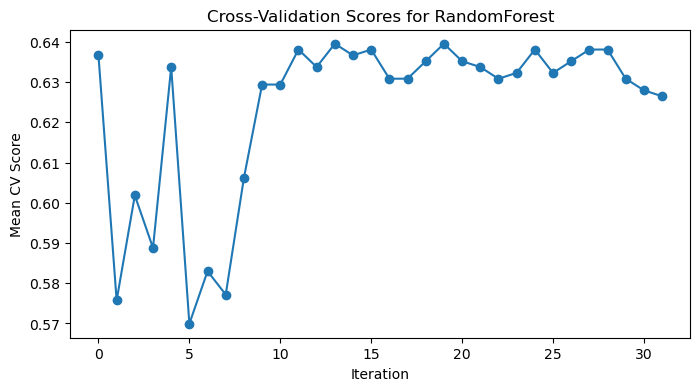

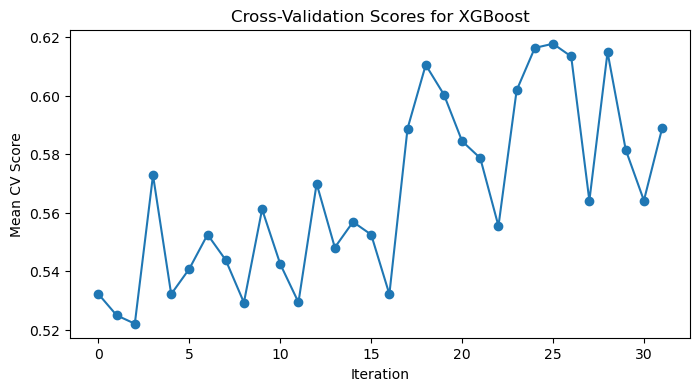

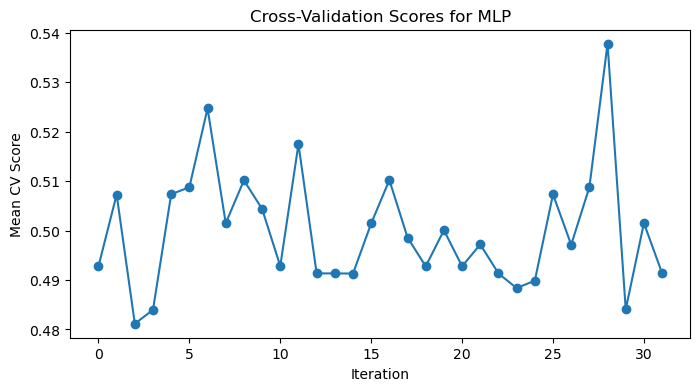

In [ ]:
import matplotlib.pyplot as plt

def plot_cv_scores(search, model_name):
    scores = search.cv_results_["mean_test_score"]
    plt.figure(figsize=(8,4))
    plt.plot(scores, marker='o')
    plt.title(f"Cross-Validation Scores for {model_name}")
    plt.xlabel("Iteration")
    plt.ylabel("Mean CV Score")
    plt.show()

# Example usage:
plot_cv_scores(rf_bayes, "RandomForest")
plot_cv_scores(xgb_bayes, "XGBoost")
plot_cv_scores(mlp_bayes, "MLP")